In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
import pickle
import matplotlib.pyplot as plt

In [8]:
from ilan_src.dataloader import *
from ilan_src.models import *
from ilan_src.utils import *

In [9]:
DATADRIVE = '/datadrive_ssd/'

In [10]:
DATADRIVE = '/datadrive_ssd/'

ds_test = pickle.load(open("/datadrive_ssd/saved_datasets/testdataset_single_forecast_only_log_trans_first_days_2.pkl", "rb"))

In [11]:
gan = LeinGANGP.load_from_checkpoint("./models/leingan/1/epoch=120-step=324279-Copy1.ckpt")

In [12]:
gen = gan.gen
gen = gen.to(device)
gen.train(False)

LeinGen(
  (embed): Conv2d(1, 255, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (process): Sequential(
    (0): LeinResBlock(
      (shortcut): Sequential()
      (convblock1): ConvBlock(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (convblock2): ConvBlock(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): LeinResBlock(
      (shortcut): Sequential()
      (convblock1): ConvBlock(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (convblock2): ConvBlock(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (upscale): Sequential(
    (0): LeinResBlock(
      (shortcut): Sequential()
      (convblock1): ConvBlock(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (convblock2): ConvBlock(
        (conv): Conv2d(256, 256, kernel_

In [13]:
sampler_test = torch.utils.data.WeightedRandomSampler(ds_test.compute_weights(), len(ds_test))
dl_test = torch.utils.data.DataLoader(
    ds_test, batch_size=32, sampler=sampler_test
)

In [14]:
def plot_samples_per_input(cond, target, gen, k=1, samples = 3):
    fig, axs = plt.subplots(k, samples+2, figsize=(15, k*5))
    gen_images = np.zeros((k,samples+2,128,128))
    with torch.no_grad():    
        for i in range(4):
            noise = torch.randn(cond.shape[0], 1, cond.shape[2], cond.shape[3]).to(device)
            pred = gen(cond, noise).detach().cpu().numpy()
            for j in range(k):
                gen_images[j,i,:,:] = pred[j, 0] 

    for j in range(k):
        lr = cond[j, 0].detach().cpu().numpy()
        hr = target[j, 0].detach().cpu().numpy()
        mn = np.min([np.min(hr), np.min(pred), np.min(gen_images[j,i,:,:])])
        mx = np.max([np.max(hr), np.max(pred), np.max(gen_images[j,i,:,:])])
        im = axs[j,0].imshow(lr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[j,0], shrink=0.7)
        im = axs[j,1].imshow(hr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[j,0], shrink=0.7)
        for i in range(samples):
            im = axs[j,i+2].imshow(gen_images[j,i,:,:], vmin=mn, vmax=mx, cmap='gist_ncar_r')
#             plt.colorbar(im, ax=axs[j,i], shrink=0.7)
    plt.show()  

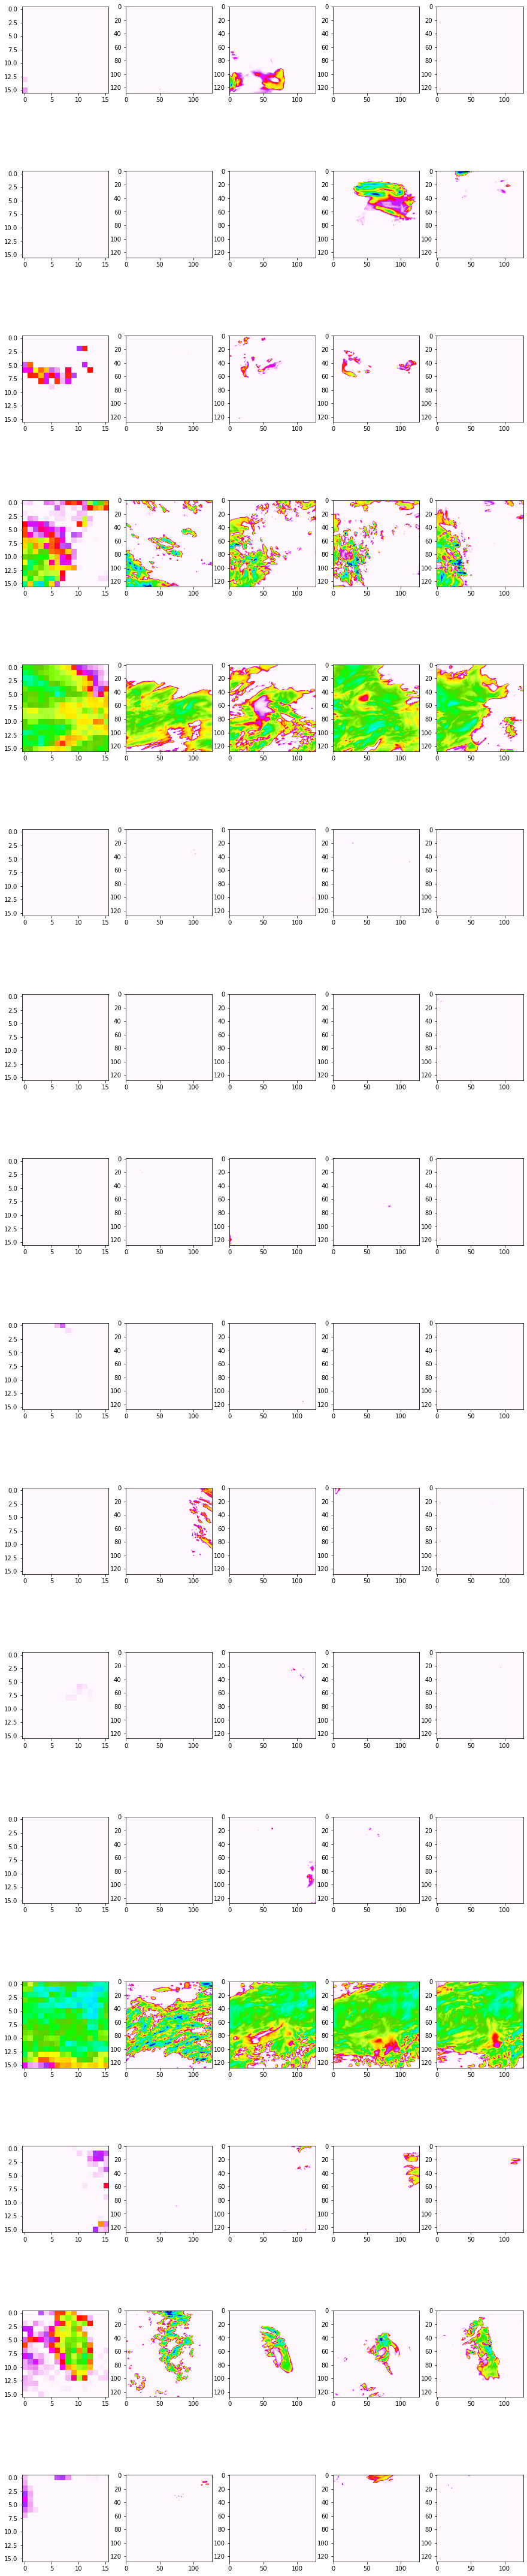

In [16]:
x_sample, y_sample = next(iter(dl_test))
x_sample, y_sample = x_sample.to(device), y_sample.to(device)
plot_samples_per_input(x_sample, y_sample, gen, k=16)

## Evaluation

### Get predictions

In [17]:
# Note that we are using xarray datasets for handling our data!
# This makes things SO MUCH easier :)
def create_valid_predictions(model, ds_valid):
    # Get predictions for full field
    preds = []
    for t in tqdm.tqdm(range(len(ds_valid.tigge.valid_time))):
        X, y = ds_valid.return_full_array(t)
        noise = torch.randn(1, 1, X.shape[1], X.shape[2]).to(device)
        pred = model(torch.FloatTensor(X[None]).to(device), noise).to('cpu').detach().numpy()[0, 0]
        preds.append(pred)
    preds = np.array(preds)
    
    # Unscale
    preds = preds * (ds_valid.maxs.tp.values - ds_valid.mins.tp.values) + ds_valid.mins.tp.values
    
    # Un-log
    if ds_valid.tp_log:
        preds = log_retrans(preds, ds_valid.tp_log)
    
    # Convert to xarray
    preds = xr.DataArray(
        preds,
        dims=['valid_time', 'lat', 'lon'],
        coords={
            'valid_time': ds_valid.tigge.valid_time,
            'lat': ds_valid.mrms.lat.isel(
                lat=slice(ds_valid.pad_mrms, ds_valid.pad_mrms+preds.shape[1])
            ),
            'lon': ds_valid.mrms.lon.isel(
                lon=slice(ds_valid.pad_mrms, ds_valid.pad_mrms+preds.shape[2])
            )
        },
        name='tp'
    )
    return preds

In [18]:
def create_valid_ensemble(model, ds_valid, nens):
    """Wrapper to create ensemble"""
    preds = [create_valid_predictions(model, ds_valid) for _ in range(nens)]
    return xr.concat(preds, 'member')

In [19]:
det_pred = create_valid_predictions(gen, ds_test)

  0%|          | 0/44 [00:00<?, ?it/s]

In [20]:
ens_pred = create_valid_ensemble(gen, ds_test, nens=10)

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

### Compute scores

In [21]:
from ilan_src.evaluation import *

Need to mask out regions where there is no radar

In [22]:
rq = xr.open_dataarray('/datadrive_ssd/mrms/4km/RadarQuality.nc')
eval_mask = rq>-1
fn = "/datadrive_ssd/mrms/4km/RadarOnly_QPE_06H/RadarOnly_QPE_06H_00.00_20180101-000000.nc"
ds = xr.open_dataset(fn)
assert eval_mask.lat.shape ==ds.lat.shape
eval_mask['lat'] = ds.lat 
assert eval_mask.lon.shape ==ds.lon.shape
eval_mask['lon'] = ds.lon

In [23]:
eval_mask

<xarray.DataArray (lat: 750, lon: 1376)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time     datetime64[ns] ...
  * lat      (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon      (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 289.9 290.0 290.0

In [24]:
mrms = ds_test.mrms.sel(lat=det_pred.lat, lon=det_pred.lon).rename(
    {'time': 'valid_time'}) * ds_test.maxs.tp.values
mrms = log_retrans(mrms, ds_test.tp_log)
mrms = mrms.where(eval_mask)

In [25]:
mrms

<xarray.DataArray 'tp' (valid_time: 44, lat: 744, lon: 1376)>
array([[[3.46944695e-18, 1.25000008e-02, 6.25000243e-03, ...,
         6.50000056e-01, 3.50000016e-01, 1.68750038e-01],
        [3.46944695e-18, 3.46944695e-18, 5.00000013e-02, ...,
         8.50000270e-01, 4.81250050e-01, 2.00000018e-01],
        [3.46944695e-18, 2.50000023e-02, 5.62499956e-02, ...,
         7.68749958e-01, 5.62500007e-01, 2.62499987e-01],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[3.46944695e-18, 3.46944695e-18, 3.46944695e-18, ...,
         3.46944695e-18, 3.46944695e-18, 3.46944695e-18],
        [3.46944695e-18, 3.46944695e-18, 3.46944695e-18, ...,
         3.46944695e-18, 3.46944695e-18, 3.46944695e-18],
        [3.46944695e-18, 3.46944695e-18, 3.46944695e-18, ...,
         3.46944695e-18, 3.46944695e-18, 3.46944695e-18],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[3.46944695e-18, 3.46944695e-18, 3.46944695e-18, ...,
         7.49999969e-01, 8.68750072e-01, 9.74999873e-01],
        [3.46944695e-18, 3.46944695e-18, 3.46944695e-18, ...,
         4.56249992e-01, 5.87499858e-01, 7.06250104e-01],
        [3.46944695e-18, 3.46944695e-18, 3.46944695e-18, ...,
         4.31250057e-01, 5.25000041e-01, 7.49999969e-01],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.4 20.36 20.32 20.28
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
    lead_time   timedelta64[ns] 12:00:00
    time        datetime64[ns] 2020-05-16

In [26]:
# Deterministic forecast RMSE
xs.rmse(det_pred, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(2.19672867)

In [27]:
# Emsemble mean forecast RMSE
xs.rmse(ens_pred.mean('member'), mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(2.02334302)

In [28]:
# Ensemble CRPS
xs.crps_ensemble(mrms, ens_pred).values

array(0.34480204)

### Interpolation baseline

In [29]:
tigge = ds_test.tigge.isel(variable=0) * ds_test.maxs.tp.values
tigge = log_retrans(tigge, ds_test.tp_log)
tigge

<xarray.DataArray (valid_time: 44, lat: 93, lon: 172)>
array([[[5.60941452e-01, 1.64720785e+00, 3.38511066e+00, ...,
         9.19832347e-01, 8.54813265e-01, 8.42504061e-01],
        [6.02257149e-01, 2.78425352e-01, 6.16120135e-01, ...,
         8.11713582e-01, 8.54883372e-01, 9.64733372e-01],
        [4.28736547e+00, 2.67114970e+00, 7.84402562e-01, ...,
         7.31913303e-01, 7.93414201e-01, 8.92297676e-01],
        ...,
        [3.46944695e-18, 3.46944695e-18, 3.46944695e-18, ...,
         3.78253297e-04, 1.30272704e-03, 6.09067775e-04],
        [5.64455592e-03, 3.46944695e-18, 3.46944695e-18, ...,
         8.79674680e-02, 3.91880913e-02, 2.56075287e-01],
        [5.51259783e-03, 1.17736924e-04, 1.84860119e-04, ...,
         5.43296803e-01, 3.98564283e-01, 3.01565931e-01]],

       [[1.61871306e+00, 8.74794607e-01, 1.59606086e+00, ...,
         2.12971381e-01, 1.41367334e-01, 9.64246056e-02],
        [8.50851288e-02, 1.49924738e-02, 1.24233834e-01, ...,
         3.11670302e-01, 1.98064654e-01, 9.83297867e-02],
        [1.12202898e+00, 3.78966073e-01, 6.23947329e-02, ...,
         4.26584770e-01, 2.74970776e-01, 1.31330623e-01],
...
        [1.28984286e-04, 1.90190943e-03, 3.46944695e-18, ...,
         3.46944695e-18, 3.46944695e-18, 3.46944695e-18],
        [1.50150789e-03, 3.46944695e-18, 9.09933210e-04, ...,
         3.46944695e-18, 3.46944695e-18, 3.46944695e-18],
        [6.35852598e-03, 3.46944695e-18, 3.46944695e-18, ...,
         3.46944695e-18, 3.46944695e-18, 3.46944695e-18]],

       [[3.46944695e-18, 3.46944695e-18, 3.46944695e-18, ...,
         9.14610321e-01, 2.57977945e-01, 1.72763468e-01],
        [3.46944695e-18, 3.46944695e-18, 3.46944695e-18, ...,
         4.31259420e-01, 5.08996330e-02, 3.98795071e-02],
        [3.46944695e-18, 3.46944695e-18, 3.46944695e-18, ...,
         2.95156623e-01, 1.32262741e-02, 1.62853613e-02],
        ...,
        [3.46944695e-18, 3.46944695e-18, 3.46944695e-18, ...,
         4.77795177e-01, 1.98326791e-01, 7.70029626e-03],
        [3.46944695e-18, 3.46944695e-18, 4.66813562e-03, ...,
         4.77190794e-01, 1.71373924e-01, 9.71573696e-03],
        [3.46944695e-18, 3.46944695e-18, 3.46944695e-18, ...,
         5.43066261e-01, 4.00218320e-01, 1.58019317e-01]]])
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    init_time   (valid_time) datetime64[ns] 2020-01-01 ... 2020-12-02
  * lon         (lon) float64 235.2 235.5 235.8 236.2 ... 289.3 289.6 289.9
  * lat         (lat) float64 49.68 49.36 49.04 48.72 ... 21.2 20.88 20.56 20.24
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
    variable    <U2 'tp'

In [30]:
interp = tigge.interp_like(mrms, method='linear')

In [31]:
# Deterministic baseline RMSE
xs.rmse(interp, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(2.17905557)

In [3]:
valid_time = 10

In [2]:
mrms.isel(valid_time=valid_time).plot(vmin=0, vmax=20)

NameError: name 'mrms' is not defined

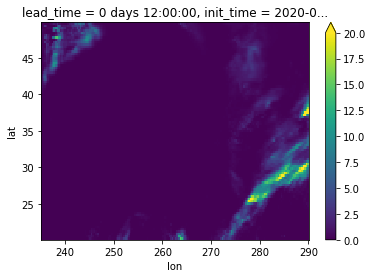

In [34]:
tigge.isel(valid_time=valid_time).plot(vmin=0, vmax=20)
# tigge.where(eval_mask)

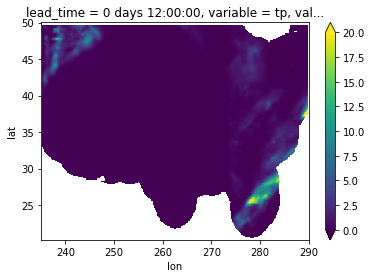

In [35]:
interp.where(eval_mask).isel(valid_time=valid_time).plot(vmin=0, vmax=20)

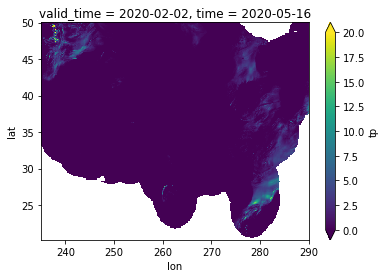

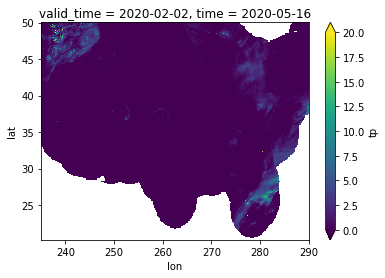

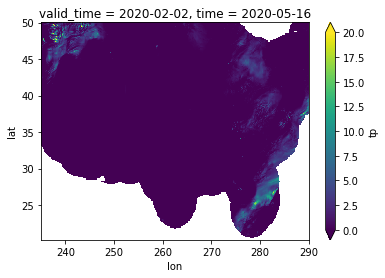

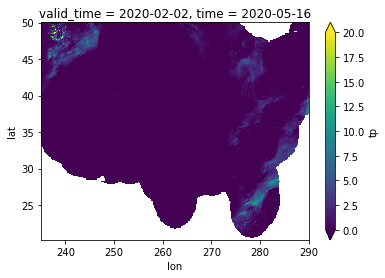

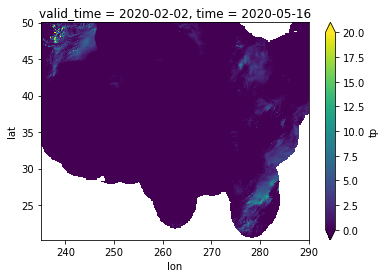

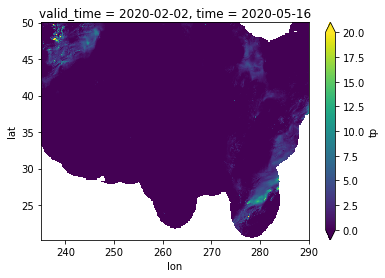

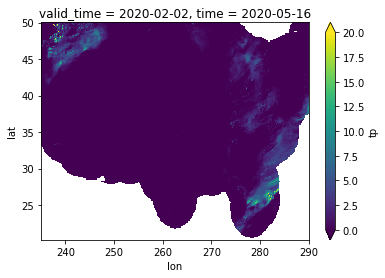

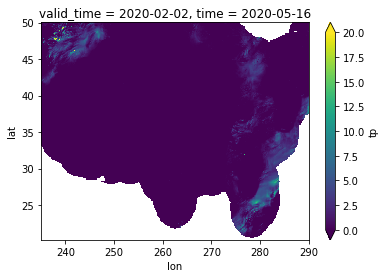

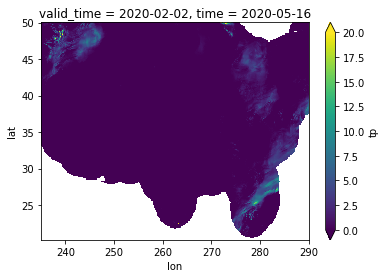

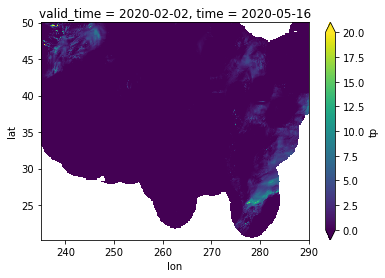

In [36]:
for i in range(10):
    plt.figure()
    ens_pred.where(eval_mask).isel(valid_time = valid_time, member=i).plot(vmin=0, vmax=20)